In [155]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [156]:
# enrichment_file = "fgsea"
enrichment_file = "gprofiler"

if enrichment_file == "fgsea": # Get fgsea results.
    enr = pd.read_csv("/users/csb/huizing/Documents/PhD/Code/mowgli_reproducibility/enrich/fgsea.csv", index_col=0)
    enr.rename(columns={"pathway": "native", "col": "dim", "pval": "p_value"}, inplace=True)
    enr["dim"] = enr["dim"].str.replace("X", "").astype(int)
    # Acutally, it should be padj instead of pval, but nothing is significant...

elif enrichment_file == "gprofiler": # Get gprofiler results. 
    enr = pd.read_csv("/users/csb/huizing/Documents/PhD/Code/mowgli_reproducibility/enrich/enrichment.csv", index_col=0)
    enr["dim"] = enr["query"].str.split(" ", expand=True)[1].astype(int)

enr["name"] = enr["native"]

In [157]:
# enr = enr[enr["source"] == "GO:MF"] # Molecular function
# enr = enr[enr["source"] == "GO:CC"] # Cellular component
# enr = enr[enr["source"] == "GO:BP"] # Biological process
# enr = enr[enr["source"] == "KEGG"] # KEGG pathways
# enr = enr[enr["source"] == "REAC"] # Reactome pathways

In [158]:
enr = enr[enr["p_value"] < .05]

In [159]:
enr["minlogp"] = -np.log10(enr["p_value"])

In [160]:
enr.head()

,source,native,name,p_value,significant,description,term_size,query_size,intersection_size,effective_domain_size,precision,recall,query,parents,method,dim,minlogp
0,PanglaoDB_Augmented_2021,Alveolar Macrophages,Alveolar Macrophages,1.896272e-18,True,NaN,123,107,24,6654,0.224299,0.195122,mofa 2,[],mofa,2,17.722099
1,PanglaoDB_Augmented_2021,Kupffer Cells,Kupffer Cells,9.670850e-14,True,NaN,137,107,21,6654,0.196262,0.153285,mofa 2,[],mofa,2,13.014535
2,PanglaoDB_Augmented_2021,Monocytes,Monocytes,1.376662e-13,True,NaN,176,107,23,6654,0.214953,0.130682,mofa 2,[],mofa,2,12.861173
3,PanglaoDB_Augmented_2021,B Cells Naive,B Cells Naive,1.702072e-13,True,NaN,151,88,20,6654,0.227273,0.132450,mofa 1,[],mofa,1,12.769022
4,PanglaoDB_Augmented_2021,Osteoclast Precursor Cells,Osteoclast Precursor Cells,2.270720e-12,True,NaN,107,107,18,6654,0.168224,0.168224,mofa 2,[],mofa,2,11.643836


## Count enrichments

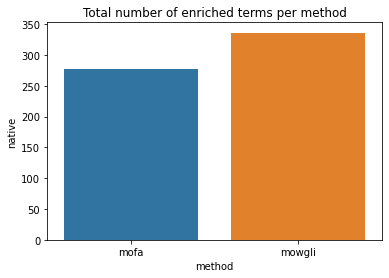

In [161]:
plt.title("Total number of enriched terms per method")
sns.barplot(data=enr.groupby("method").count().reset_index(), x="method", y="native")
plt.show()

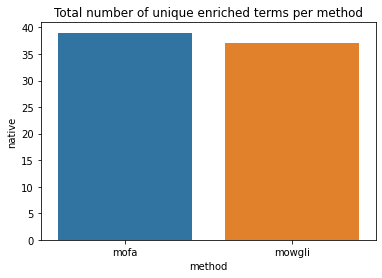

In [162]:
plt.title("Total number of unique enriched terms per method")
sns.barplot(data=enr.groupby("method")["native"].nunique().reset_index(), x="method", y="native")
plt.show()

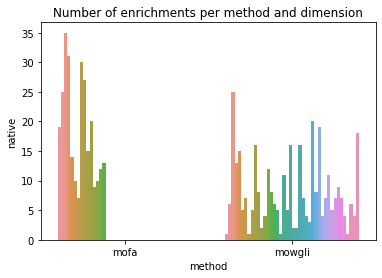

In [163]:
fig, ax = plt.subplots(1, 1)
sns.barplot(data=enr.groupby(["method", "dim"])["native"].count().reset_index(), x="method", y="native", hue="dim", ax=ax)
ax.get_legend().remove()
ax.set_title("Number of enrichments per method and dimension")
plt.show()

## Check specificity

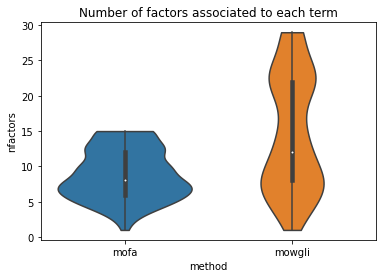

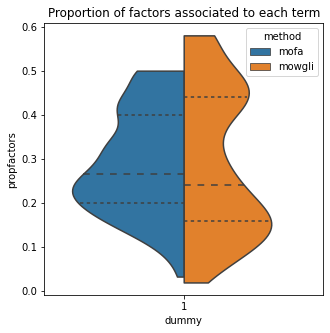

In [164]:
enr["nfactors"] = 0
nfactors = enr.groupby(["native", "method"])["native"].count()
enr.set_index(["native", "method"], inplace=True)
enr.loc[nfactors.index, "nfactors"] = nfactors
enr.reset_index(inplace=True)

plt.title("Number of factors associated to each term")
sns.violinplot(data=enr, x="method", y="nfactors", cut=0)
plt.show()

enr["ndim"] = 0
enr.loc[enr["method"] == "mofa", "ndim"] = 30
enr.loc[enr["method"] == "mowgli", "ndim"] = 50
enr["propfactors"] = enr["nfactors"] / enr["ndim"]
enr["dummy"] = 1

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.set_title("Proportion of factors associated to each term")
sns.violinplot(
    data=enr,
    x="dummy",
    hue="method",
    y="propfactors",
    split=True,
    ax=ax,
    inner="quart",
    cut=0,
)
plt.show()


In [181]:
selectivity_mofa = (enr[enr["method"] == "mofa"]["native"].nunique() + 30) / (2*enr[enr["method"] == "mofa"]["native"].count())
selectivity_mowgli = (enr[enr["method"] == "mowgli"]["native"].nunique() + 50) / (2*enr[enr["method"] == "mowgli"]["native"].count())
print("Selectivity of MOFA+: {:.4f}".format(selectivity_mofa))
print("Selectivity of Mowgli: {:.4f}".format(selectivity_mowgli))

Selectivity of MOFA+: 0.1245
Selectivity of Mowgli: 0.1295


## Biology-driven check

In [166]:
enr.head()

,native,method,source,name,p_value,significant,description,term_size,query_size,intersection_size,...,precision,recall,query,parents,dim,minlogp,nfactors,ndim,propfactors,dummy
0,Alveolar Macrophages,mofa,PanglaoDB_Augmented_2021,Alveolar Macrophages,1.896272e-18,True,NaN,123,107,24,...,0.224299,0.195122,mofa 2,[],2,17.722099,8,30,0.266667,1
1,Kupffer Cells,mofa,PanglaoDB_Augmented_2021,Kupffer Cells,9.670850e-14,True,NaN,137,107,21,...,0.196262,0.153285,mofa 2,[],2,13.014535,6,30,0.200000,1
2,Monocytes,mofa,PanglaoDB_Augmented_2021,Monocytes,1.376662e-13,True,NaN,176,107,23,...,0.214953,0.130682,mofa 2,[],2,12.861173,9,30,0.300000,1
3,B Cells Naive,mofa,PanglaoDB_Augmented_2021,B Cells Naive,1.702072e-13,True,NaN,151,88,20,...,0.227273,0.132450,mofa 1,[],1,12.769022,10,30,0.333333,1
4,Osteoclast Precursor Cells,mofa,PanglaoDB_Augmented_2021,Osteoclast Precursor Cells,2.270720e-12,True,NaN,107,107,18,...,0.168224,0.168224,mofa 2,[],2,11.643836,7,30,0.233333,1


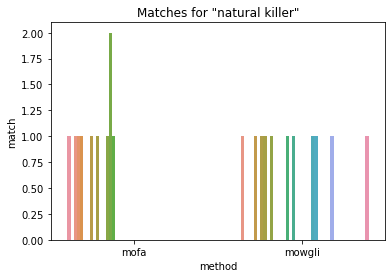

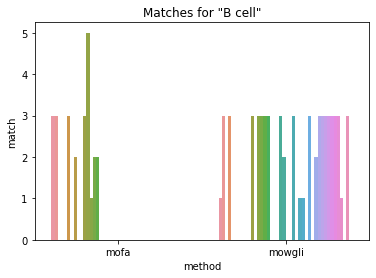

In [167]:
def barplot_matches(keywords, case=False):
    enr["match"] = enr["name"].str.contains(keywords, case=case)
    fig, ax = plt.subplots(1, 1)
    sns.barplot(
        data=enr.groupby(["method", "dim"])["match"].sum().reset_index(),
        x="method",
        y="match",
        hue="dim",
        ax=ax,
    )
    ax.set_title(f'Matches for "{keywords}"')
    ax.get_legend().remove()
    plt.show()


barplot_matches("natural killer")
barplot_matches("B cell")


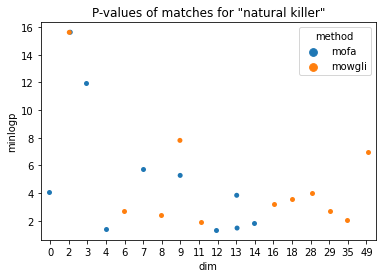

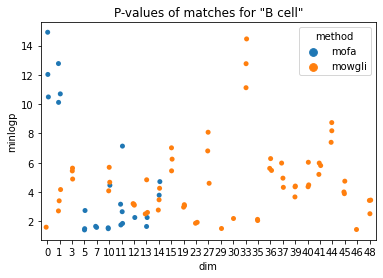

In [169]:
def stripplot_matches(keywords, case=False):
    fig, ax = plt.subplots(1, 1)
    sns.stripplot(
        data=enr[enr["name"].str.contains(keywords, case=case)],
        x="dim",
        y="minlogp",
        hue="method",
    )
    ax.set_title(f"P-values of matches for \"{keywords}\"")
    plt.show()

stripplot_matches("natural killer")
stripplot_matches("B cell")